# Probing for an Empirical Formula for Transmitted E for Gaussian Beams

$$J(x,y):=\frac{2E_p}{\pi w^2}e^{\frac{-2}{w^2}(x^2 + y^2)}$$
$$\Delta J(J):= J(\alpha_0+\frac{\alpha_s}{1+J/J_s})$$
Properties of graphene: $$J_s = 0.00000015\text{ } \text{uJum}^{-2}, \alpha_0 = 0.01725, \alpha_s=0.00575$$
Experimental setup values: $$E_p \approx 0.0003\text{ } \text{uJ}, w=34\text{ } \text{um}$$
We could start off by focusing on the following approximation for miniscule stripe thicknesses:
$$E_{tot} \approx^{?}  \%_{grp}\cdot\iint_{-\infty}^{\infty}(J-\Delta J)dxdy + \%_{abl} \cdot\iint_{-\infty}^{\infty}Jdxdy = E_p - \%_{grp} \iint_{-\infty}^{\infty}\Delta Jdxdy$$

In [1]:
from beam import *
from sympy import *
from scipy import integrate
init_printing(use_unicode=True, use_latex=True)

In [2]:
x,y = symbols('x,y')
E_p,a_0,a_s,J_s,E_tot,p_grp,p_abl,w = symbols('E_p,a_0,a_s,J_s,E_tot,p_grp,p_abl,w', positive=True)
J = S(2)*E_p*exp((-2/(w**2))*(x**2 + y**2))/(pi*(w**2))
J_red = J*(a_0+(a_s)/(S(1) + J/J_s))

# The experimental setup had the following parameters:
J_exp = J.subs({w:34,E_p:0.0003})
J_red_exp = J_red.subs({a_0:0.01725,a_s:0.00575,J_s:0.00000015,w:34,E_p:0.0003})
# numpy functions for J_exp and J_red_exp:
npJ_exp = lambdify((x,y), J_exp, 'numpy')
npJ_red_exp = lambdify((x,y), J_red_exp, 'numpy')
# numpy function for J transmitted through graphene:
npJ_aftermath_exp = lambdify((x,y), J_exp-J_red_exp, 'numpy')

# E_tot approximation(p_grp) for miniscule stripes case, for experimental setup:
E_tot_ministripes_exp = lambda x: (0.0003 - np.multiply((x/100), integrate.nquad(npJ_red_exp,[[-np.inf,np.inf],[-np.inf,np.inf]])[0]))

# Initializing a Gaussian beam with the experimental setup values:
beam_exp = beam_initialize(Ep=0.0003,threshold=10**-12,res=30,w=34)

In [3]:
# We should get E_p when we integrate npJ_exp over x,y from -inf to inf:
print(f"Integral evaluates as: {integrate.nquad(npJ_exp,[[-np.inf,np.inf],[-np.inf,np.inf]])[0]}")

Integral evaluates as: 0.00030000170272928404


In [4]:
# For full graphene, the experimental loss is (x2 as the beam crosses twice):
print(200*(0.0003 - E_tot_ministripes_exp(100))/0.0003,"% loss")

4.227182699771349 % loss


In [5]:
# For 50% graphene, let us compare the results:
beam_exp_actual_E_p = integrate_for_energy(beam_exp)
graphene_layer_50pc = mask_initialize(beam=beam_exp,shape='lines',width=0.035,thickness=0.035)
beam_exp_aftermath = integrate_for_energy(mask_apply(beam_exp,graphene_layer_50pc))
print(loss_calc(beam_exp_actual_E_p, beam_exp_aftermath, 2, percent=True),"% loss calculated by beam.py simulation")
print(200*(0.0003 - E_tot_ministripes_exp(50))/0.0003,"% loss calculated by approximation for mini stipes")

2.1126130279837487 % loss calculated by beam.py simulation
2.1135913498856747 % loss calculated by approximation for mini stipes


In [3]:
# Now we can check up to what thickness this approximation holds with some acceptable error
# We can also see if there is some easy way to calculate the fluctuations for this case and may be able to extend it to other cases

# Let us define the following function to ease the process:

def fluctuation_checker(beam, width_config):  # width_config is a list with entries: [d_grp, d_abl]
    results = []  # results list will contain energy integral values(wrt offset 1um per step) of each config
    Einput_actual = integrate_for_energy(beam)

    for i in range(len(width_config)):
        mm = mask_initialize(beam=beam, shape='lines', width=width_config[i][0], thickness=width_config[i][1], crop=False)
        stepsize = int(np.ceil(width_config[i][0] + width_config[i][1]))
        itrtr = mask_slide_iterator(beam=beam,mask=mm,stepsY=stepsize)  # Slider slides graphene layer about 1um at a time
        tmp = []
        for j in itrtr:
            k = integrate_for_energy(j[1])
            tmp.append(k)
            del(j)
        results.append(tmp)
        del(mm)
        del(itrtr)

    dE_E = []  # dE_E will hold loss% values calculated from the results list
    for i in range(len(width_config)):
        dE_E.append([(200*(Einput_actual - j)/Einput_actual) for j in results[i]])  # 100*2*ΔE/E values are calculated, x2 is needed as the beam passes through the mask twice, the effect caused by the energy drop before the second pass is neglected
    for i in range(len(width_config)):
        plt.plot(dE_E[i], label=f"{(width_config[i][0],width_config[i][1])} um")
    plt.ylabel('Loss (%)')
    plt.xlabel('Sliding Offset (um)')
    plt.legend(loc = 'best')
    plt.show()


    dE_E_diff = [200*(max(i)-min(i))/((sum(i))/len(i)) for i in dE_E]
    plt.plot([i for i in range(len(width_config))], dE_E_diff,'o')
    plt.ylabel(r'% Change in Loss over Mean Loss')
    plt.xlabel('Stripe Config No.')
    plt.show()
    
    return dE_E_diff

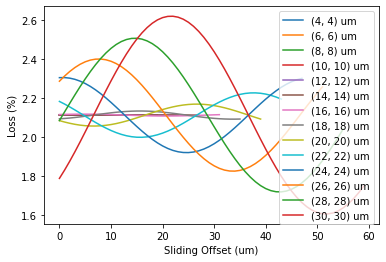

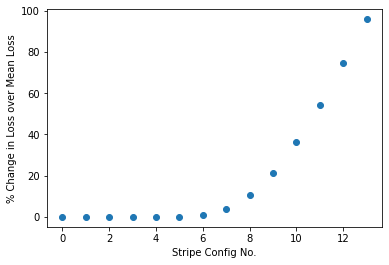

In [14]:
fluctuation_checker(beam_exp,[[i,i] for i in range(4,32,2)])

In [11]:
# For 25% graphene, let us compare the results:
beam_exp_actual_E_p = integrate_for_energy(beam_exp)
graphene_layer_25pc = mask_initialize(beam=beam_exp,shape='lines',width=0.1,thickness=0.3)
beam_exp_aftermath = integrate_for_energy(mask_apply(beam_exp,graphene_layer_25pc))
print(loss_calc(beam_exp_actual_E_p, beam_exp_aftermath, 2, percent=True),"% loss calculated by beam.py simulation")
print(200*(0.0003 - E_tot_ministripes_exp(25))/0.0003,"% loss calculated by approximation for mini stipes")

1.0563162001675321 % loss calculated by beam.py simulation
1.0567956749428191 % loss calculated by approximation for mini stipes


## Hypothesis:
$$E_{after} \approx \Phi(d_{grpwidth})\cdot\sin(2\pi \frac{x}{d_{totwidth}}) + E_p - \%_{grp} \iint_{-\infty}^{\infty}\Delta Jdxdy,$$
$$\text{where }\Phi \text{ is some function, probably exponential, may be dependant on $\%_{grp}$ as well, x offset wrt pad init}$$

In [8]:
dE_E_diff

There seems to be a region where the fluctuations are negligible (where $d_{totwidth} < w$ maybe??), and then the fluctuation range linearly increases as we widen the stripes. Let us see if this occurs with a different graphene percentage, say 25%. Then we may look if this is an overarching effect for many configurations.

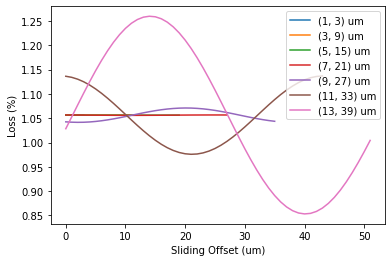

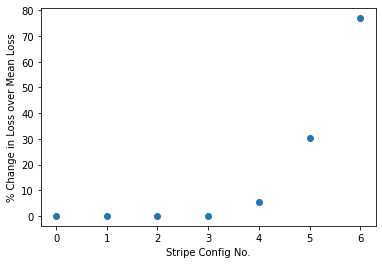

In [13]:
fluctuation_checker(beam_exp,[[i,3*i] for i in range(1,14,2)])

The fluctuations are again negligible where $d_{totwidth} < w$ for 25% graphene case. Let us see if this holds for some higher $E_p$ value, let us change it to x10 while keeping other constants the same, look for 50% graphene case:

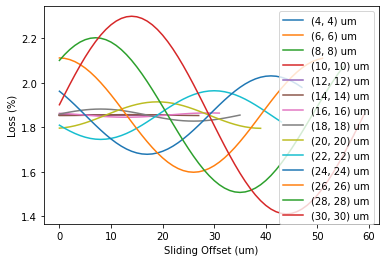

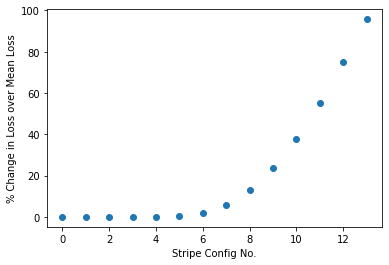

In [4]:
beam_x10Ep = beam_initialize(Ep=0.003,threshold=10**-12,res=30,w=34)
fluctuation_checker(beam_x10Ep,[[i,i] for i in range(4,32,2)])

It looks promising. Also mind that the change in loss over mean loss slope is very similar to the case with x10 lower $E_p$

After some more tinkering, we could infer that fluctuation is negligible for any $E_p$ value if the total width of a period ($d_{totwidth}$, which is $d_{grp} + d_{abl}$) does not exceed $w$, and this may hold even for materials other than graphene, which may have different $\alpha_0,\alpha_s,J_s$ values.

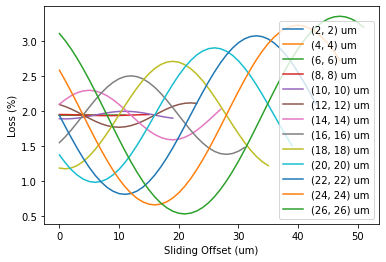

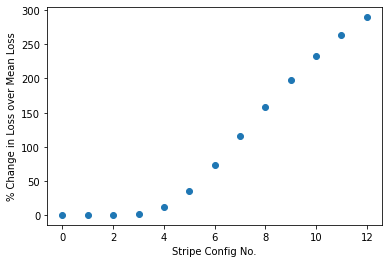

In [5]:
beam_halfw = beam_initialize(Ep=0.0003,threshold=10**-12,res=30,w=17)
fluctuation_checker(beam_halfw,[[i,i] for i in range(2,28,2)])

There may be a third region of interest for % change in loss over mean loss. The first one is for the $d_{totwidth} < w$ case, at which the fluctuation is negligible, then there comes a linear increase in fluctuation range, and a third region may arise, or the second region may be actually logarithmic that looks linear when $d_{totwidth} < c\cdot w$, c may be a constant or some function.

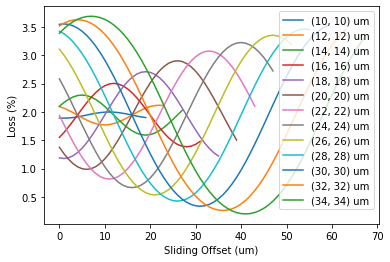

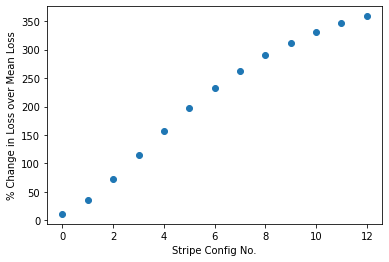

In [6]:
# Let us see what happens when we take a look at the d_totwidth > w case:
fluctuation_checker(beam_halfw,[[i,i] for i in range(10,36,2)])  #w=17um

We can see that for $E_p=0.0003\text{uJ},w=17\text{um}$, we get negligible fluctuation for $d_{totwidth} < w$ and a linear increase in fluctuation for about $w < d_{totwidth} < 3w$. Up to this point, we can see that keeping $d_{totwidth}$ below $w$ is good for getting a non-fluctuating $E_{after}$ reading.